# 패키지 임포트

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import warnings
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings(action='ignore') 

from MulticoreTSNE import MulticoreTSNE as TSNE

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [3]:
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

# 데이터 관리

In [28]:
df = pd.read_csv('./data.csv', encoding='cp949')
dataDF = pd.DataFrame(data=df)
df.head()

,TAG_MIN,배정번호,건조 1존 OP,건조 2존 OP,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입1존 OP,소입2존 OP,소입3존 OP,...,소입로 CP 값,소입로 CP 모니터 값,소입로 온도 1 Zone,소입로 온도 2 Zone,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone
0,2022-01-03 11:22:07,102410,75.6648,30.0155,NaN,NaN,68.4386,72.84030,59.7862,51.71690,...,0.450421,NaN,NaN,859.854,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-03 11:22:08,102410,75.6706,32.2732,NaN,NaN,68.4386,78.44150,61.6286,50.44530,...,0.450356,1.146260e-10,860.338,859.780,860.044,859.786,294.658,272.538,328.734,328.865
2,2022-01-03 11:22:09,102410,75.6776,32.1592,98.8533,99.14600,68.4386,78.10990,61.5414,52.01960,...,0.450341,1.145200e-10,860.338,859.780,859.981,859.724,294.658,272.538,328.734,328.805
3,2022-01-03 11:22:11,102410,75.8656,30.8312,98.7918,99.17675,68.4999,77.50725,60.6663,52.69425,...,0.450201,1.144670e-10,860.338,859.842,859.950,859.599,294.719,272.538,328.674,328.865
4,2022-01-03 11:22:12,102410,73.6468,29.5274,98.7918,99.20750,68.4386,76.02620,61.1634,51.69150,...,0.450235,1.145360e-10,860.351,859.791,859.991,859.731,294.721,272.599,328.740,328.808


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2939722 entries, 0 to 2939721
Data columns (total 21 columns):
 #   Column             Dtype  
---  ------             -----  
 0   TAG_MIN            object 
 1   배정번호               int64  
 2   건조 1존 OP           float64
 3   건조 2존 OP           float64
 4   건조로 온도 1 Zone      float64
 5   건조로 온도 2 Zone      float64
 6   세정기                float64
 7   소입1존 OP            float64
 8   소입2존 OP            float64
 9   소입3존 OP            float64
 10  소입4존 OP            float64
 11  소입로 CP 값           float64
 12  소입로 CP 모니터 값       float64
 13  소입로 온도 1 Zone      float64
 14  소입로 온도 2 Zone      float64
 15  소입로 온도 3 Zone      float64
 16  소입로 온도 4 Zone      float64
 17  솔트 컨베이어 온도 1 Zone  float64
 18  솔트 컨베이어 온도 2 Zone  float64
 19  솔트조 온도 1 Zone      float64
 20  솔트조 온도 2 Zone      float64
dtypes: float64(19), int64(1), object(1)
memory usage: 471.0+ MB


In [ ]:
plt.figure(figsize=(25,15))
target_cor = df.corr()
sns.heatmap(target_cor, annot=True, fmt=".2f", cmap ='coolwarm')
plt.savefig('savefig_peerson.png')
plt.show()

In [10]:
dataDF_outdate=dataDF.iloc[:,1:]

In [11]:
dataDF_outdate = dataDF_outdate.interpolate(method='linear')

In [12]:
dataDF_outdate.shape

(2939722, 20)

In [13]:
df118005 = dataDF_outdate[dataDF_outdate['배정번호'] == 118005]

In [14]:
dfcol=dataDF_outdate.columns

# 데이터 시각화

## box Plot

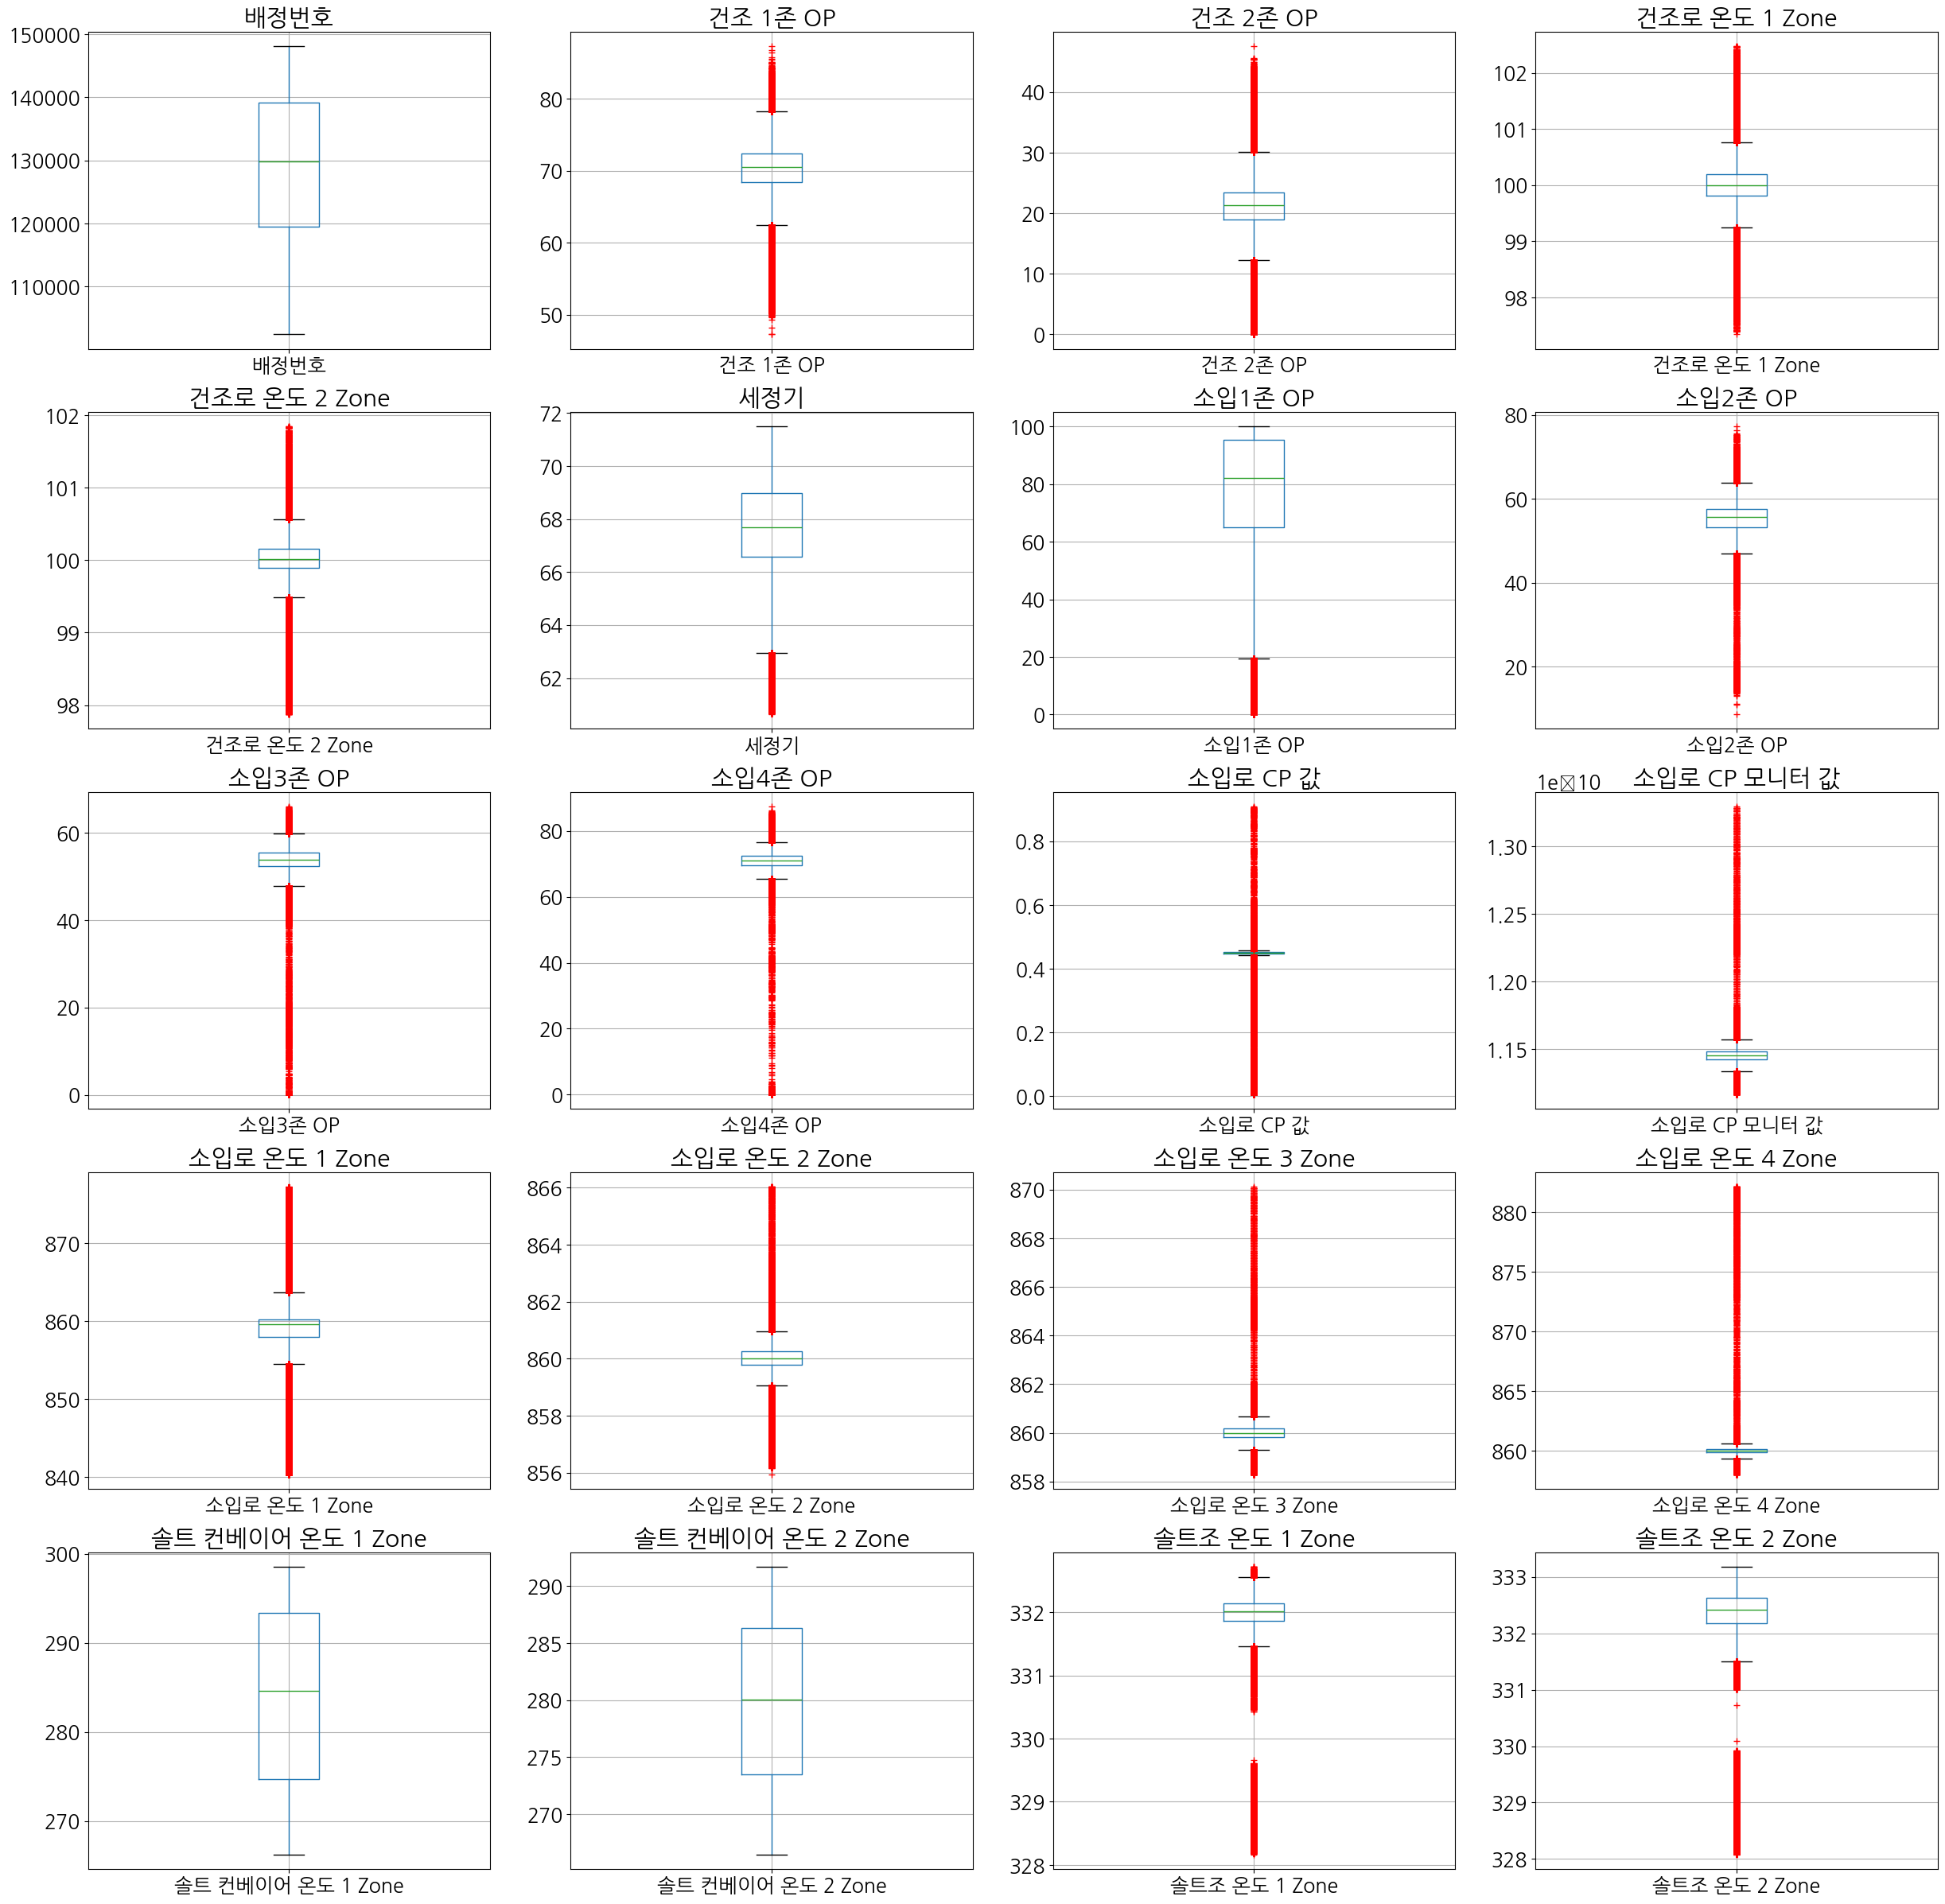

In [15]:
fig, axes = plt.subplots(5, 4, figsize=(30, 30))

# 각 열에 대한 박스플롯 그리기
for i, column in enumerate(dataDF_outdate.columns):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    dataDF_outdate.boxplot(column, ax=ax,sym='r+')
    ax.set_title(column)

## 선형 그래프

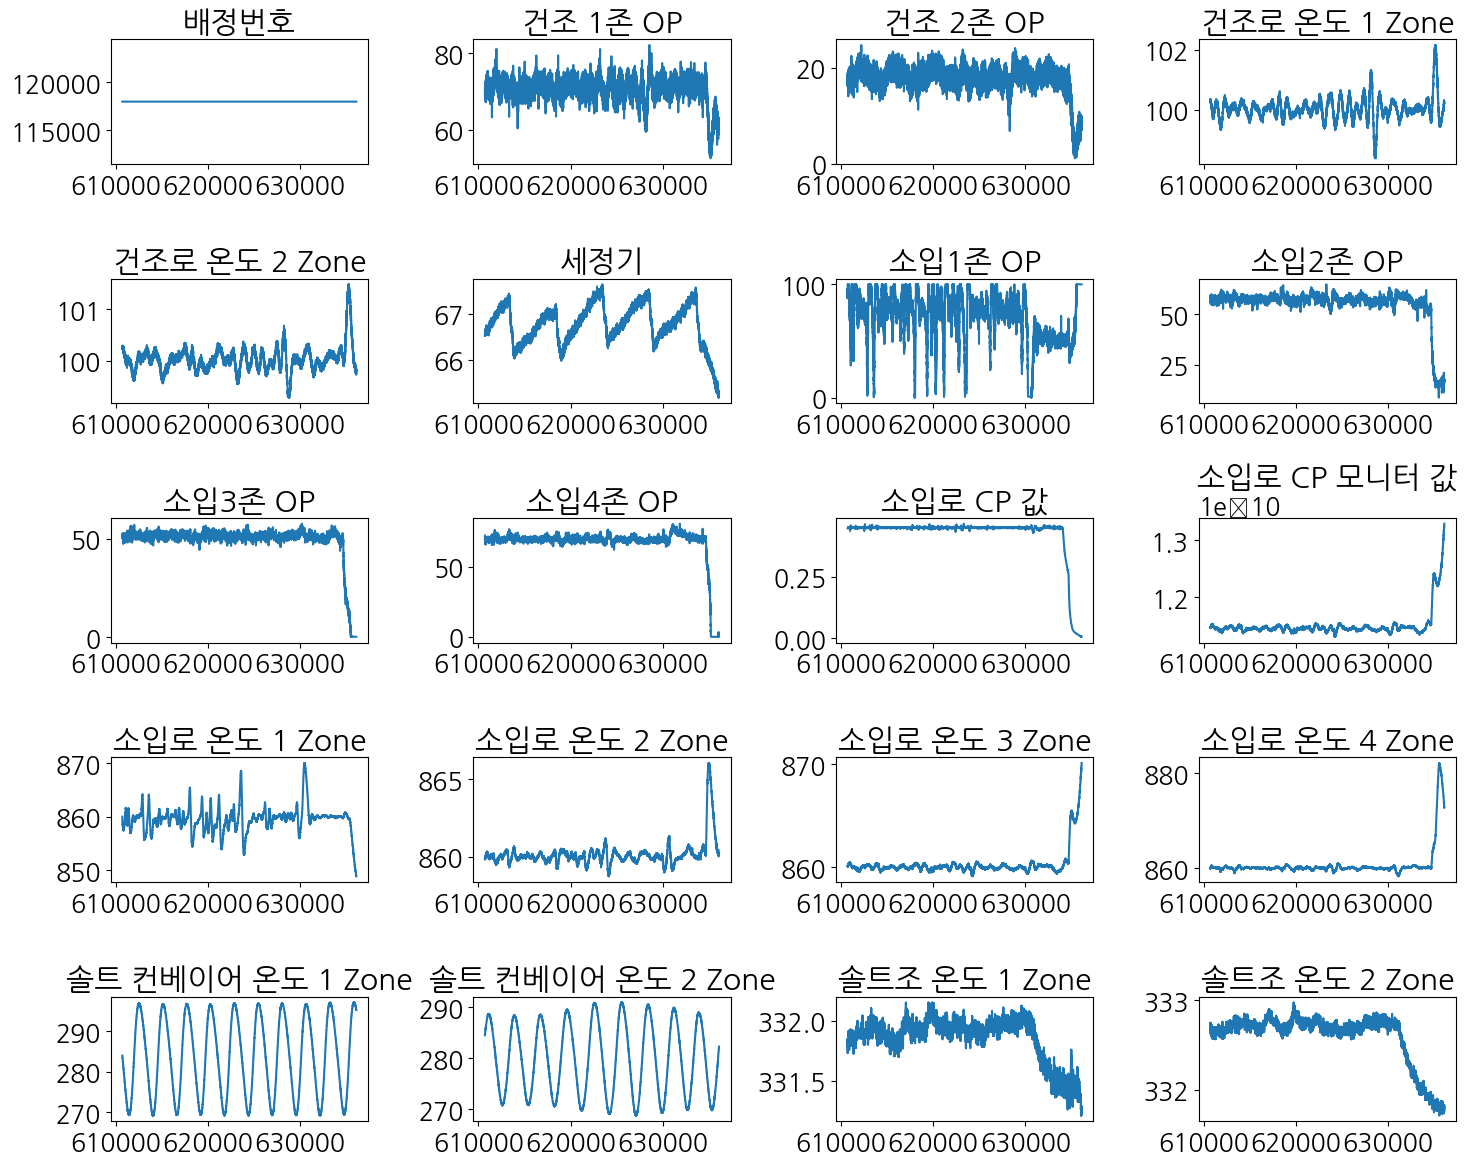

In [24]:
fig, axes = plt.subplots(5, 4, figsize=(15, 12))

for i, column in enumerate(df118005.columns):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.plot(df118005[column])
    ax.set_title(f'{column}')

# 그래프 간 간격 조절
plt.tight_layout()

# 그래프 표시
plt.show()

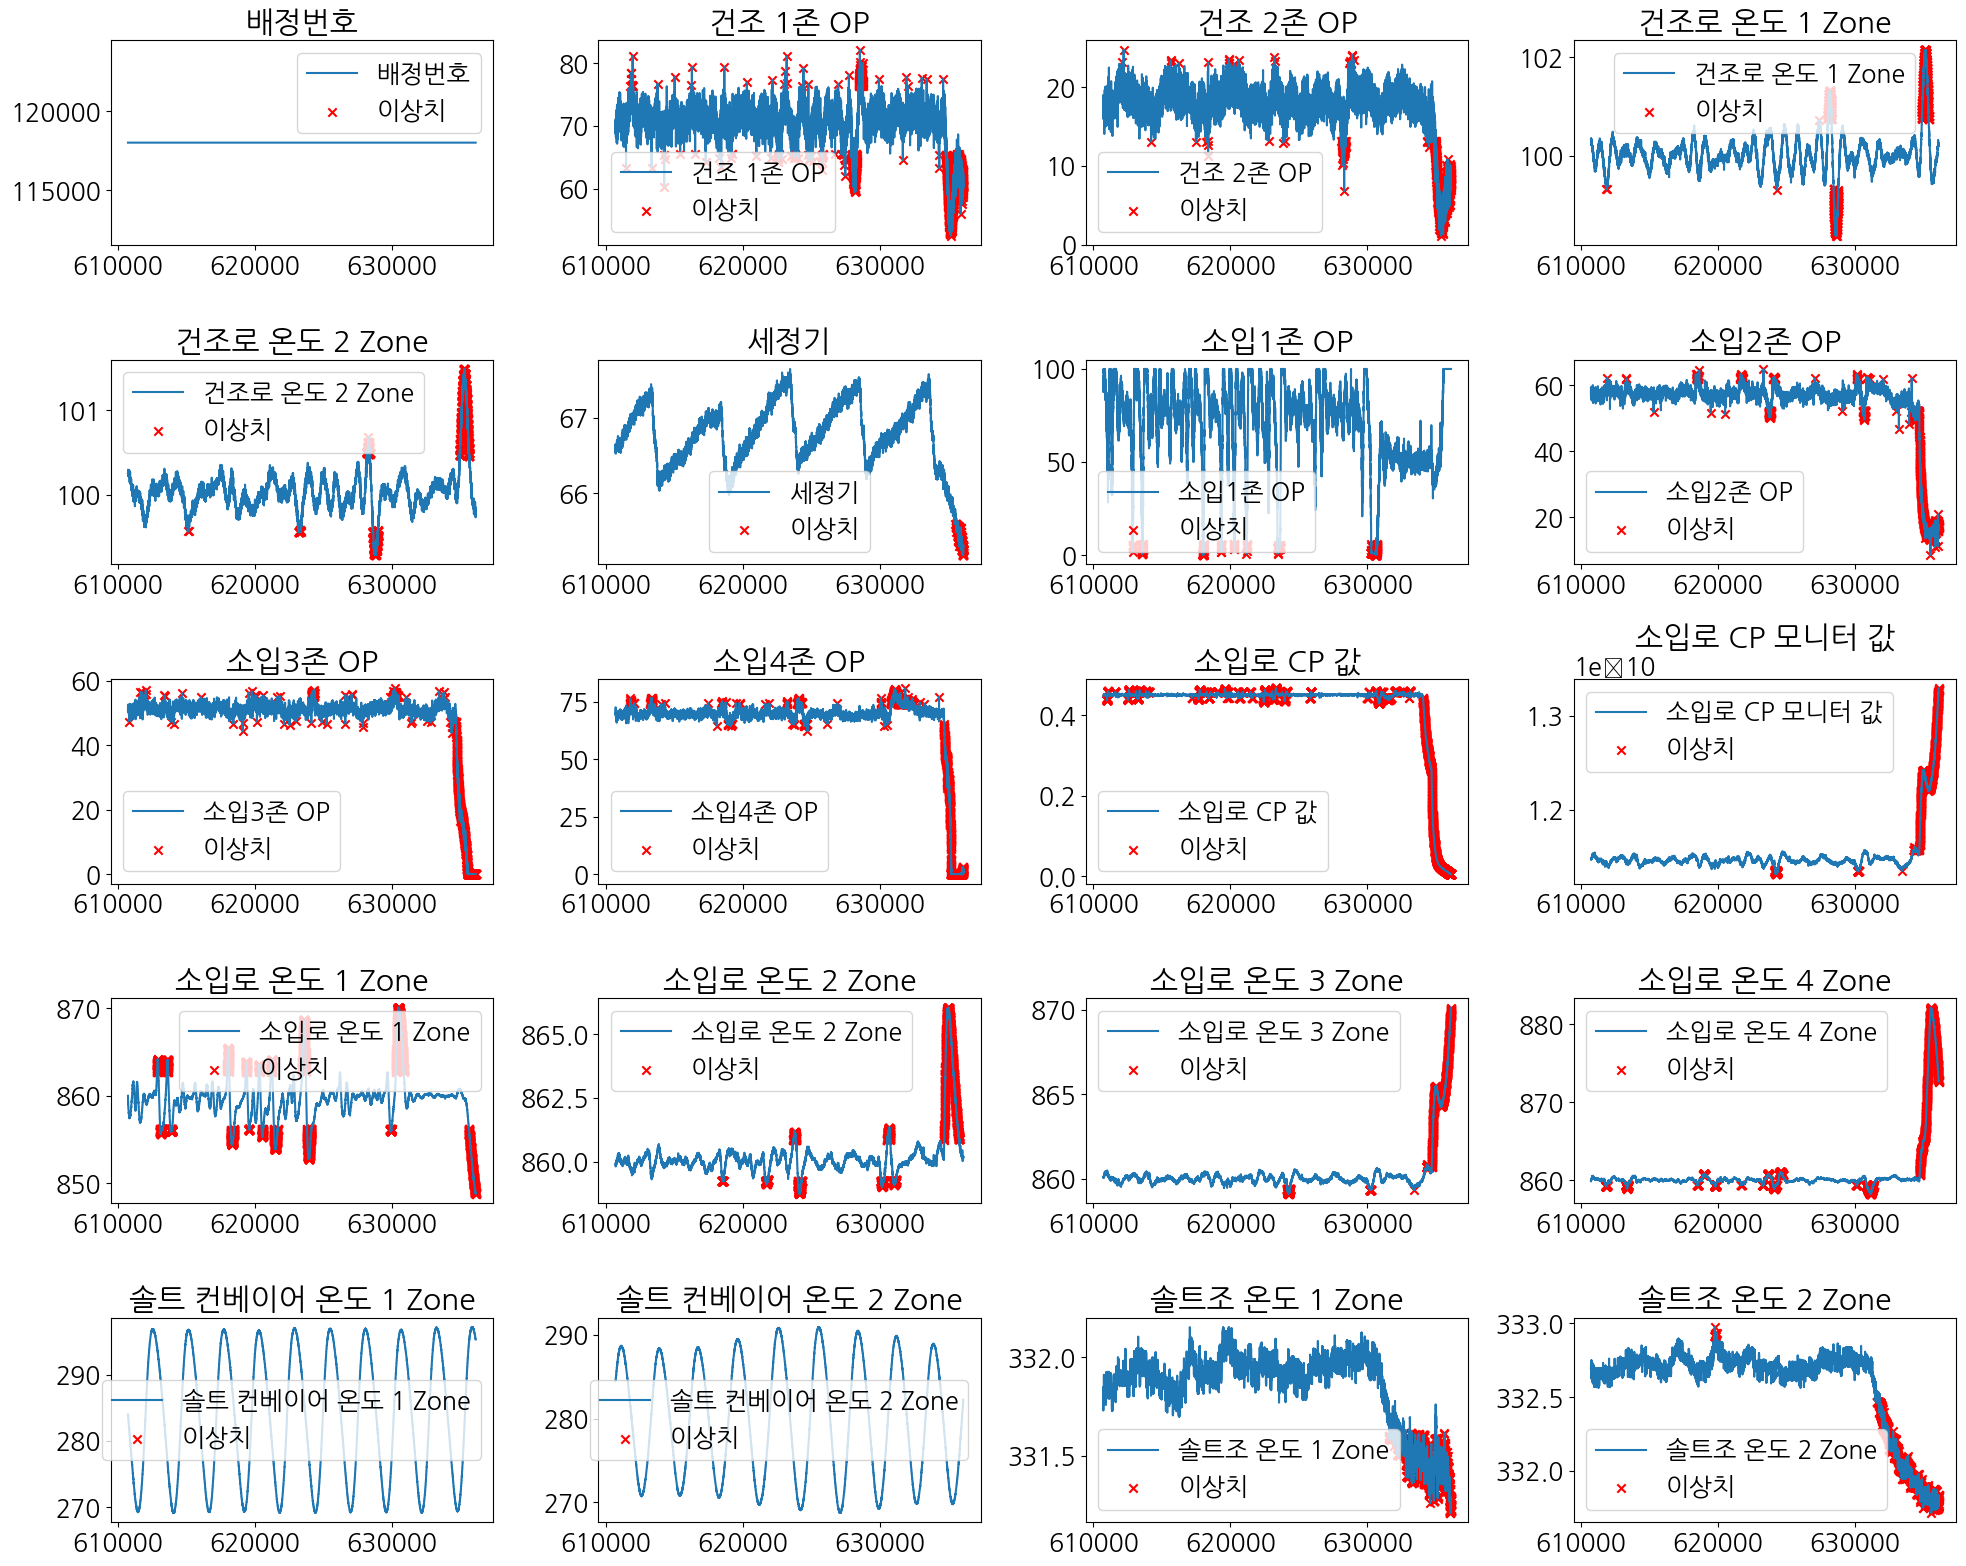

In [23]:
# 2행 2열로 선형 그래프 그리기
fig, axes = plt.subplots(5, 4, figsize=(20, 16))

for i, column in enumerate(df118005.columns):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # 각 열에 대한 선형 그래프 그리기
    ax.plot(df118005[column], label=column)

    # IQR을 사용하여 이상치 식별
    Q1 = df118005[column].quantile(0.25)
    Q3 = df118005[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 이상치를 'x'로 표시
    outliers = df118005[(df118005[column] < lower_bound) | (df118005[column] > upper_bound)]
    ax.scatter(outliers.index, outliers[column], marker='x', color='red', label='이상치')

    ax.set_title(f'{column}')
    ax.legend()

# 그래프 간 간격 조절
plt.tight_layout()

# 그래프 표시
plt.show()

## 상관 계수

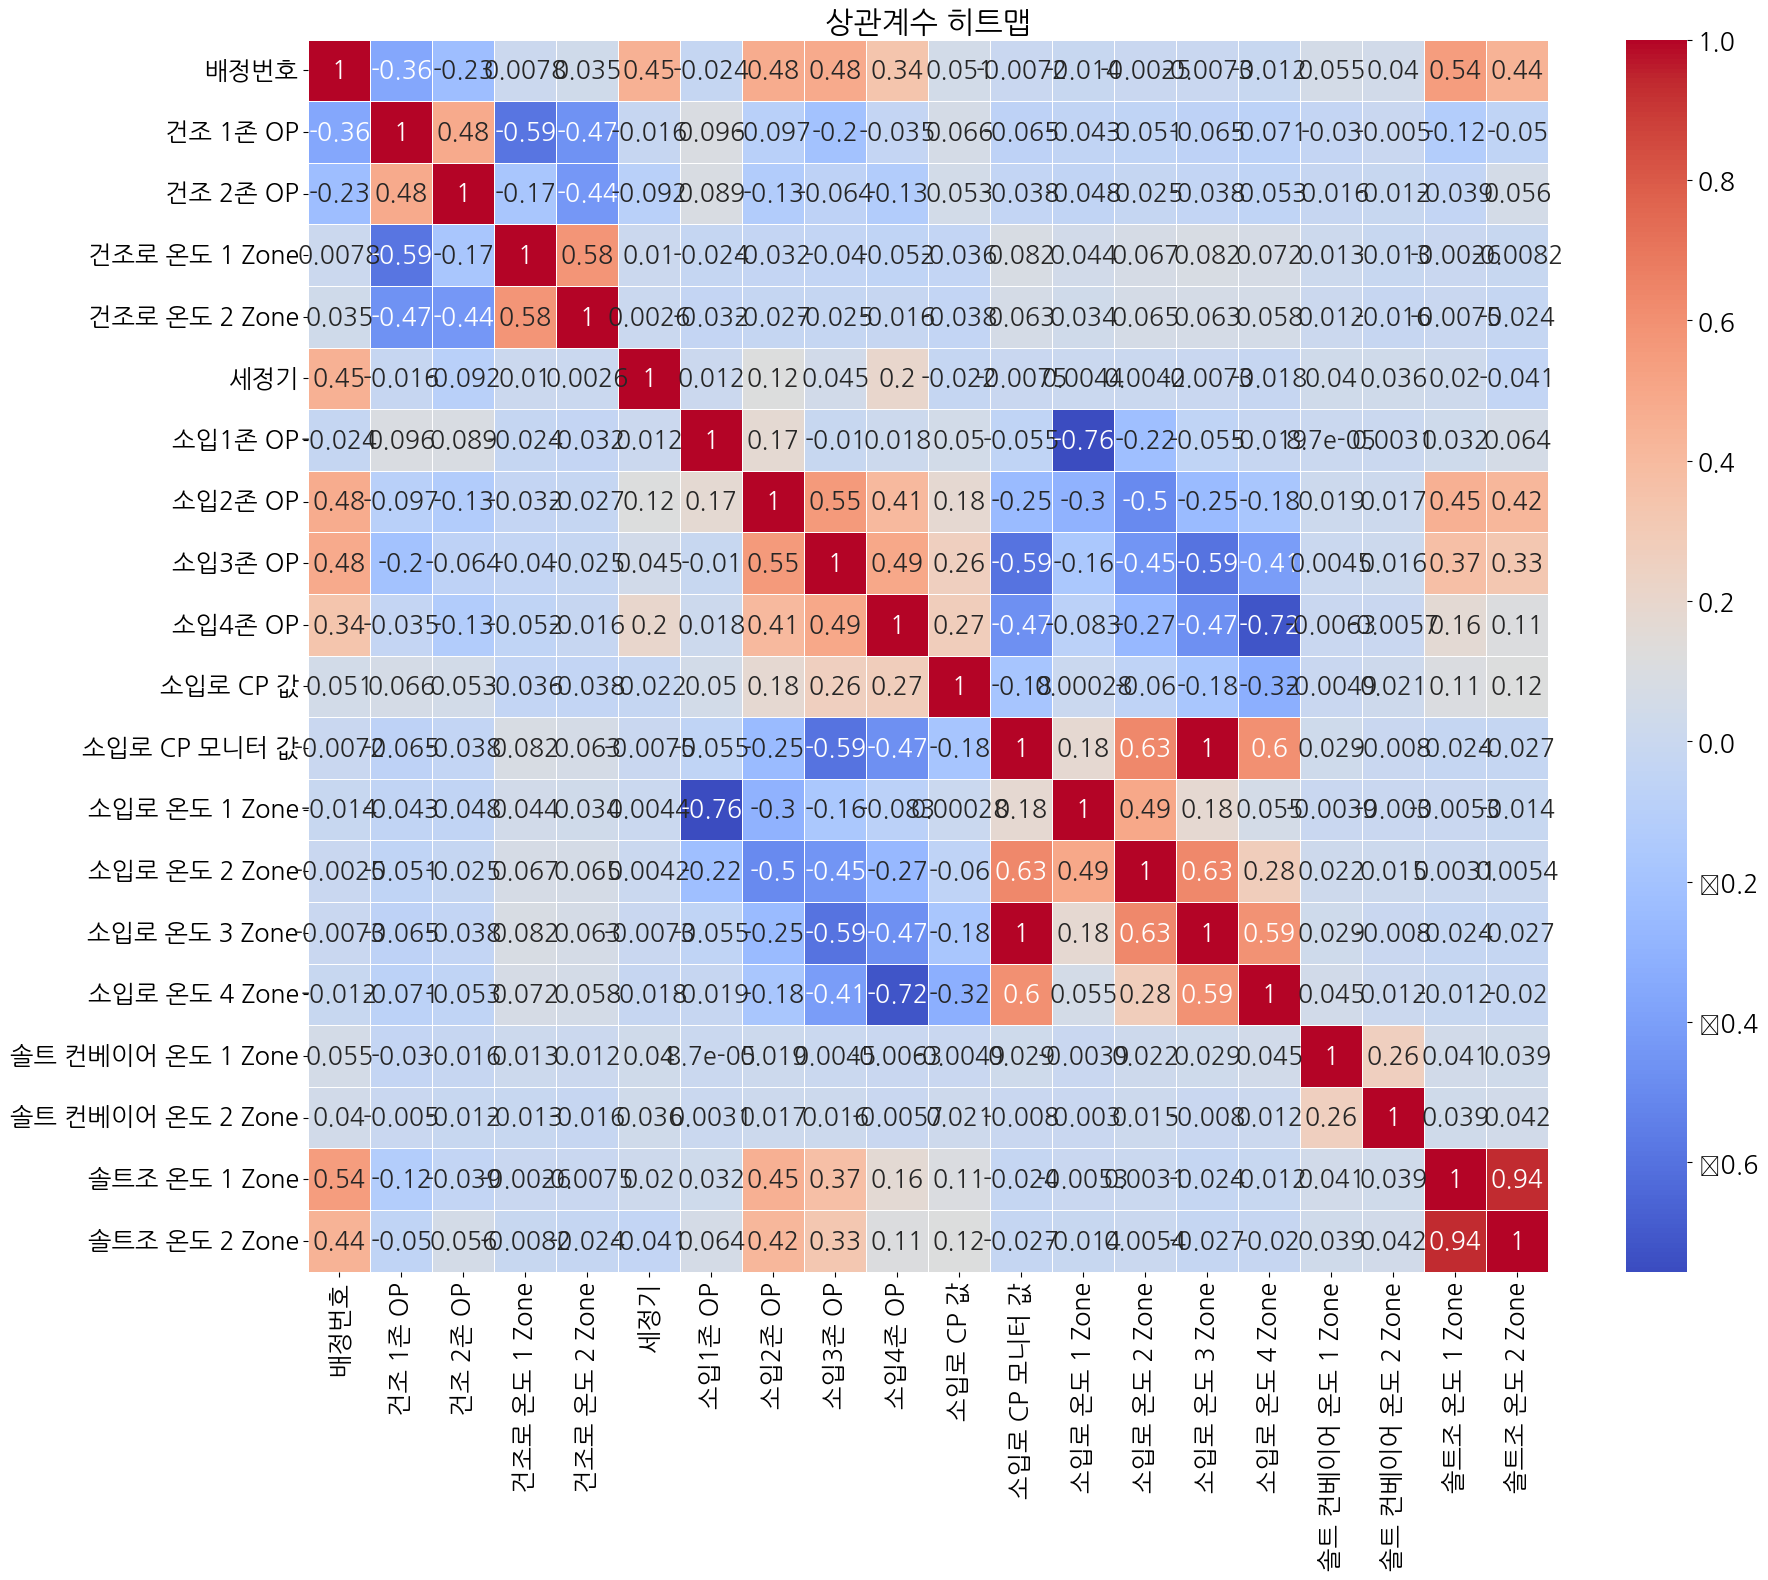

In [26]:
#상관 계수
import seaborn as sns

# 상관계수 행렬 생성
correlation_matrix = dataDF_outdate.corr()

# 히트맵 그리기
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('상관계수 히트맵')
plt.show()


# 라벨링

In [347]:
da = df['배정번호']

In [350]:
df.drop(['TAG_MIN', '배정번호',], inplace=True, axis=1)

In [351]:
df = df.interpolate(method='values')

In [352]:
df.dropna(axis=0, inplace=True)

## IQR

In [366]:
df['IQR이상치개수'] =0
for col in df.columns:
    thirdq, firstq = df[col].quantile(0.75), df[col].quantile(0.25)
    interquartilerange = 1.5 * (thirdq - firstq)
    outlierhigh, outlierlow = interquartilerange + thirdq, firstq - interquartilerange

    outlier_indices = df[(df[col] > outlierhigh) | (df[col] < outlierlow)].index
    for idx in outlier_indices:
        df.loc[idx, 'IQR이상치개수'] += 1
print(df['IQR이상치개수'].value_counts())

IQR이상치개수
0     1524840
1      425992
2      272065
4      251066
3      248894
5      113255
7       53902
8       28034
9       13061
10       5142
11       1462
12        442
13        425
15        382
14        309
16        286
17        163
Name: count, dtype: int64


## z-score

In [ ]:
from scipy.stats import zscore

# z-score 계산
z_scores = np.abs(zscore(df))

# z-score가 3보다 큰 값을 이상치로 판단
df['z-score이상치개수'] = (z_scores > 3).sum(axis=1)

#df['anomaly'] = np.where(da['z-score이상치개수'] < 11, 1, -1)
print(df['z-score이상치개수'].value_counts())

## 라벨링

In [405]:
df['z_anomaly'] = np.where(df['z-score이상치개수'] < 9, 0, 1)
df['IQR_anomaly'] =np.where(df['IQR이상치개수'] < 8, 0, 1)

In [406]:
df['설비 이상신호'] = np.where((df['z_anomaly']==1) & (df['IQR_anomaly']==1), 1, 0)

In [407]:
df.head()
dd = df.drop(['IQR이상치개수', 'z-score이상치개수','z_anomaly','IQR_anomaly'], axis=1)

104126

In [408]:
print(dd['설비 이상신호'].value_counts())

설비 이상신호
0    2938787
1        933
Name: count, dtype: int64


In [409]:
dd['배정번호'] = da

In [410]:
df_sample = dd[(dd['배정번호']==118005) | (dd['배정번호']==104126)]

In [411]:
x = df_sample.drop(['설비 이상신호'], axis=1)
y = df_sample['설비 이상신호']

In [412]:
print(y.value_counts())

설비 이상신호
0    37003
1      933
Name: count, dtype: int64


## TSNE 분석

In [413]:
tsne = TSNE(n_jobs= -1)
X_tsne = tsne.fit_transform(x)


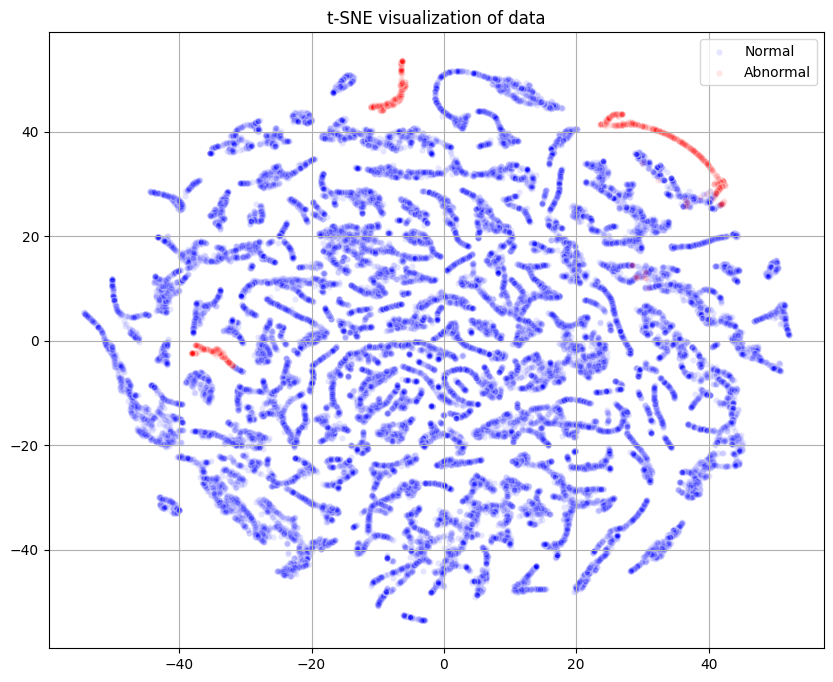

In [414]:
# Plot the results
plt.figure(figsize=(10, 8))

# Create a scatter plot for normal and abnormal points
plt.scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], c='blue', label='Normal', edgecolors='w', s=20, alpha = 0.1)
plt.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], c='red', label='Abnormal', edgecolors='w', s=20, alpha = 0.1)

plt.legend(loc="upper right")
plt.title('t-SNE visualization of data')
plt.grid(True)
plt.savefig('./th98_tsne.png')
plt.show()
